In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

train_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Train'
val_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Validation'
test_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Test'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Added dropout to prevent overfitting
x = Dense(3, activation='softmax')(x)  # 3 classes: 5, 6, 7

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Checkpoint to save the best model
checkpoint_filepath = '/content/drive/MyDrive/best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model with model saving
history = model.fit(
    train_generator,
    epochs=30,  # Increased number of epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, model_checkpoint]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Predicting on new data
predictions = model.predict(test_generator)

# Save the final model with the .keras extension
final_model_filepath = '/content/drive/MyDrive/final_model.keras'
model.save(final_model_filepath)


Found 5240 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3733 - loss: 1.1511
Epoch 1: val_accuracy improved from -inf to 0.40462, saving model to /content/drive/MyDrive/best_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 1465s 9s/step - accuracy: 0.3733 - loss: 1.1508 - val_accuracy: 0.4046 - val_loss: 1.0876 - learning_rate: 1.0000e-04
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3904 - loss: 1.0931
Epoch 2: val_accuracy did not improve from 0.40462
164/164 ━━━━━━━━━━━━━━━━━━━━ 69s 402ms/step - accuracy: 0.3904 - loss: 1.0931 - val_accuracy: 0.4046 - val_loss: 1.0911 - learning_rate: 1.0000e-04
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4004 - loss: 1.0893
Epoch 3: val_accuracy did not improve from 0.40462
164/164 ━━━━━━━━━━━━━━━━━━━━ 68s 395ms/step - accuracy: 0.4004 - loss: 1.0893 - val_accuracy: 0.4046 - val_loss: 1.0864 - learning_rate: 1.0000e-04
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4038 - loss: 1.0882
Epoch 4:

Found 650 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: 5


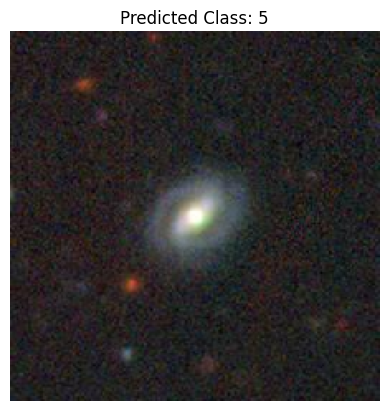

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 338s 17s/step


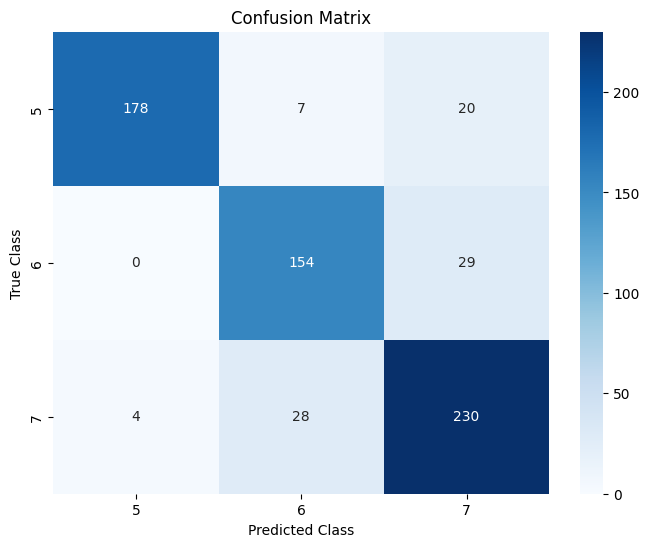

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = load_model('/content/drive/MyDrive/best_model.keras')

# Define the path to the test directory
test_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Test'  # Replace with the path to your test directory

# Create an ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load one test image
test_image_path = '/content/drive/MyDrive/data/sdss_dataset_split/Test/5/image_104_class_5.jpg'  # replace with the actual path to your test image
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # rescale

# Predict the class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)
class_names = list(test_generator.class_indices.keys())
print(f'Predicted Class: {class_names[predicted_class[0]]}')

# Display the image
plt.imshow(img)
plt.title(f'Predicted Class: {class_names[predicted_class[0]]}')
plt.axis('off')
plt.show()

# Generate predictions for all test images and create a confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Set the paths for your training, validation, and test datasets
train_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Train'
val_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Validation'
test_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Test'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # 3 classes: 5, 6, 7

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and data generators for loading images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width),
                                                batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
                                                  batch_size=batch_size, class_mode='categorical')

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Predicting on new data
predictions = model.predict(test_generator)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 5240 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 1602s 9s/step - accuracy: 0.3914 - loss: 1.8970 - val_accuracy: 0.5323 - val_loss: 0.9964
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 387ms/step - accuracy: 0.4700 - loss: 1.0578 - val_accuracy: 0.5431 - val_loss: 0.9576
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 384ms/step - accuracy: 0.4991 - loss: 1.0123 - val_accuracy: 0.5108 - val_loss: 0.9983
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 386ms/step - accuracy: 0.4773 - loss: 1.0268 - val_accuracy: 0.5554 - val_loss: 0.9354
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 391ms/step - accuracy: 0.5202 - loss: 0.9722 - val_accuracy: 0.5169 - val_loss: 0.9712
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 391ms/step - accuracy: 0.5257 - loss: 0.9742 - val_accuracy: 0.5831 - val_loss: 0.9057
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.5444 - loss: 0.9659 - val_accuracy: 0.5831 - val_loss: 0.9239
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 381ms/step - accuracy: 0.5520 - loss: 0.9502 - val_

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Set the paths for your training, validation, and test datasets
train_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Train'
val_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Validation'
test_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Test'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased units and added L2 regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(3, activation='softmax')(x)  # 3 classes: 5, 6, 7

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Increased rotation range
    width_shift_range=0.3,  # Increased shift range
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    brightness_range=[0.8, 1.2],  # Added brightness range
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Checkpoint to save the best model
checkpoint_filepath = '/content/drive/MyDrive/best_model_new.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model with model saving
history = model.fit(
    train_generator,
    epochs=50,  # Increased number of epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Predicting on new data
predictions = model.predict(test_generator)

# Save the final model with the .keras extension
final_model_filepath = '/content/drive/MyDrive/final_model_new.keras'
model.save(final_model_filepath)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 5240 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3518 - loss: 10.6411 
Epoch 1: val_accuracy improved from -inf to 0.43538, saving model to /content/drive/MyDrive/best_model_new.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 2130s 12s/step - accuracy: 0.3518 - loss: 10.6375 - val_accuracy: 0.4354 - val_loss: 8.8311 - learning_rate: 1.0000e-05
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.3895 - loss: 8.3810
Epoch 2: val_accuracy improved from 0.43538 to 0.45692, saving model to /content/drive/MyDrive/best_model_new.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 80s 471ms/step - accuracy: 0.3895 - loss: 8.3782 - val_accuracy: 0.4569 - val_loss: 6.9737 - learning_rate: 1.0000e-05
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4634 - loss: 6.6039
Epoch 3: val_accuracy improved from 0.45692 to 0.70000, saving model to /content/drive/MyDrive/best_model_new.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.4638 - loss: 6.6015 - val_accuracy: 0.7000 - va

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
import numpy as np
print(tf.__version__)

# Paths to directories
train_dir = r'/content/drive/MyDrive/data/sdss_dataset_split/Train'
validation_dir = r'/content/drive/MyDrive/data/sdss_dataset_split/Validation'
test_dir = r'/content/drive/MyDrive/data/sdss_dataset_split/Test'

# Data Augmentation and Rescaling for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )


# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    )

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    )

# Testing Data Generator (No data augmentation for testing)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical')

# Transfer learning with VGG16
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

input_tensor = Input(shape=(224, 224, 3))
x = base_model(input_tensor)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator)

# Evaluating the model on test data

loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f'Validation Accuracy: {accuracy*100:.2f}%')
model.save('/content/drive/MyDrive/classifier2.h5')
model = load_model('/content/drive/MyDrive/classifier2.h5')

# Function to preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Load and preprocess the image
img_path = r'/content/drive/MyDrive/data/sdss_dataset_split/Test/5/image_104_class_5.jpg'  # Adjust path as necessary
img_array = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class = np.argmax(predictions, axis=-1)

# Assuming your data generator is train_generator
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predicted_label = class_labels[predicted_class[0]]
print(f'Predicted label: {predicted_label}')




2.17.0
Found 5240 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Epoch 1/30
   1/1310 ━━━━━━━━━━━━━━━━━━━━ 48:55 2s/step - accuracy: 0.7500 - loss: 1.1214

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load your trained model
model = tf.keras.models.load_model('C:/Users/DELL/Documents/MarineTech/classifier.h5')

# Mapping of class labels
class_indices = {
    0: 'Class1 - SEABASS ADVANCED(MATURED) STAGE FEMALE EGGS',
    1: 'Class2 - SEABASS FEMALE 22072024',
    2: 'Class3 - SEABASS FEMALE MATURED16072027',
    3: 'Class4 - SEABASS MALE 22072024',
    4: 'Class5 - SEABASSMALE16072024'
}

# Function to preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Function to predict and display image with bounding box and label
def predict_and_display_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_indices[predicted_class]

    # Display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_class

# Test images and their true labels
image_paths = [
 'C:\Users\shivn\Downloads\galaxy project\galaxyy\galaxies\Test\5\image_7_class_5.jpg',
 'C:\Users\shivn\Downloads\galaxy project\galaxyy\galaxies\Test\5\image_40_class_5.jpg',
 'C:\Users\shivn\Downloads\galaxy project\galaxyy\galaxies\Test\5\image_58_class_5.jpg'
]

# Manually map true labels according to the paths provided
true_labels = [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4]  # Adjust according to the actual labels

predicted_labels = []

for img_path in image_paths:
    predicted_class = predict_and_display_image(img_path)
    predicted_labels.append(predicted_class)

# Visualize confusion matrix and other metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_indices.values()), yticklabels=list(class_indices.values()))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(true_labels, predicted_labels, target_names=list(class_indices.values()))
print(report)